In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from typing import Any
import matplotlib.pyplot as plt

class APIClient: #базовый класс для всех API
    base_url: str = ""

    def get(self,  endpoint: str, params: dict[str, Any])-> dict[str, Any]: #получение запроса
       #выполняет GET запрос по API
        url = f"{self.base_url}{endpoint}"
        try:
            response = requests.get(url, params=params, timeout=10) #ответ, полученный от сервера
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print(f"[Ошибка запроса] {e}")
            return {}

class Bitget(APIClient): 
    base_url = "https://api.bitget.com"

    def __init__(self, symbol: str, product_type: str, granularity: str):
        self.symbol:str = symbol
        self.product_type:str = product_type
        self.granularity:str = granularity

class LoadingCandle: #загружает свечи
    def __init__(self, client: Bitget, days:int = 365):
        self.client: Bitget = client
        self.days: int = days
        self.endpoint: str = "/api/v2/mix/market/candles"
    def get_candle(self)-> list[list[Any]]:
        # время
        end_time: datetime = datetime.now() # текущее время
        start_time: datetime = end_time - timedelta(days=self.days) # начальное время 
        # перевод в секунды
        end_ms: int = int(end_time.timestamp() * 1000)
        start_ms: int = int(start_time.timestamp() * 1000)

        all_candles: list[list[Any]] = []
        current_end: int = end_ms
        max_needed: int = self.days * 24  #  свечи максимум
        while len(all_candles) < max_needed:
            params: dict[str, Any] = {
                "symbol": self.client.symbol,
                "productType": self.client.product_type,
                "granularity": self.client.granularity,
                "endTime": current_end,
                "limit": 1000
            }

            raw: dict[str, Any] = self.client.get(self.endpoint, params)

            if raw.get("code") != "00000":
                print("Ошибка API:", raw)
                break

            data: list[list[Any]] = raw.get("data")
            if not data:
                print("Нет данных:", raw)
                break

            all_candles.extend(data)

            print(f"Загружено {len(all_candles)} свечей...")

            oldest_candle: int = int(data[-1][0]) # берём время самой старой свечи
            if oldest_candle <= start_ms:
                break

            current_end = oldest_candle - 1
        return all_candles

class CandleProcesssing: #обработка свечей
    def __init__(self, candles: list[list[Any]]):
        # Ппреобразование в DataFrame
        self.df = pd.DataFrame(candles, columns=[
            "timestamp", "open", "high", "low", "close", "volume", "quoteVolume"
        ])
    def prepare(self)-> pd.DataFrame:
        # Конвертация timestamp
        self.df["timestamp"] = pd.to_datetime(self.df["timestamp"].astype(float)/1000, unit='s', utc=True)
        #сортировка
        self.df = self.df.sort_values("timestamp").reset_index(drop=True)
        # Удаляем дубликаты
        self.df = self.df.drop_duplicates(subset="timestamp").reset_index(drop=True)
        return self.df
    
    def save_candle(self, filename: str = "candles_1h.csv") -> None: #сохранение
        self.df.to_csv(filename, index=False)
        # print(f"Сохранено. Всего свечей: {len(df)}")

class TechIndicator:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.alerts_up = pd.DataFrame()
        self.alerts_down = pd.DataFrame()

    def add_indicators(self, window: int) -> pd.DataFrame:
        self.df["close"] = self.df["close"].astype(float)
        self.df["SMA"] = self.df["close"].rolling(window).mean()
        self.df["EMA"] = self.df["close"].ewm(window, adjust=False).mean()
        #считаем отклонения
        limit:float = 0.5 / 100 
        self.df["diff"] = (self.df["close"] - self.df["SMA"]) / self.df["SMA"]

        # Находим индексы, где diff > 0.1% или diff < -0.1%
        self.alerts_up = self.df[self.df["diff"] > limit]
        self.alerts_down = self.df[self.df["diff"] < -limit]
        return self.df

class PriceGraph:
    def __init__(self, df: pd.DataFrame, symbol: str):
        self.df: pd.DataFrame = df
        self.symbol: str = symbol

    def plot(self, window: int, alerts_up: pd.DataFrame, alerts_down: pd.DataFrame)-> None:
        plt.figure(figsize=(20,9))
        plt.plot( self.df["timestamp"], self.df["close"].astype("float64"), label="Close Price", color="blue")
        plt.plot( self.df["timestamp"], self.df["SMA"], label=f"SMA {window}", color="red")
        plt.plot( self.df["timestamp"], self.df["EMA"], label=f"EMA {window}", color="green")
        #рисуем на графике отклонения
        plt.scatter(alerts_up["timestamp"], alerts_up["close"], color="magenta", marker="*", label="Отклонение вверх")
        plt.scatter(alerts_down["timestamp"], alerts_down["close"], color="black", marker="o", label="Отклонение вниз")
        
        plt.title(f"Почасовой график {self.symbol}")
        plt.xlabel("Время")
        plt.ylabel("Цена (USDT)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()



Загружено 1000 свечей...
Загружено 2000 свечей...
Загружено 3000 свечей...
Загружено 4000 свечей...
Загружено 5000 свечей...
Загружено 6000 свечей...
Загружено 7000 свечей...
Загружено 8000 свечей...
Загружено 9000 свечей...


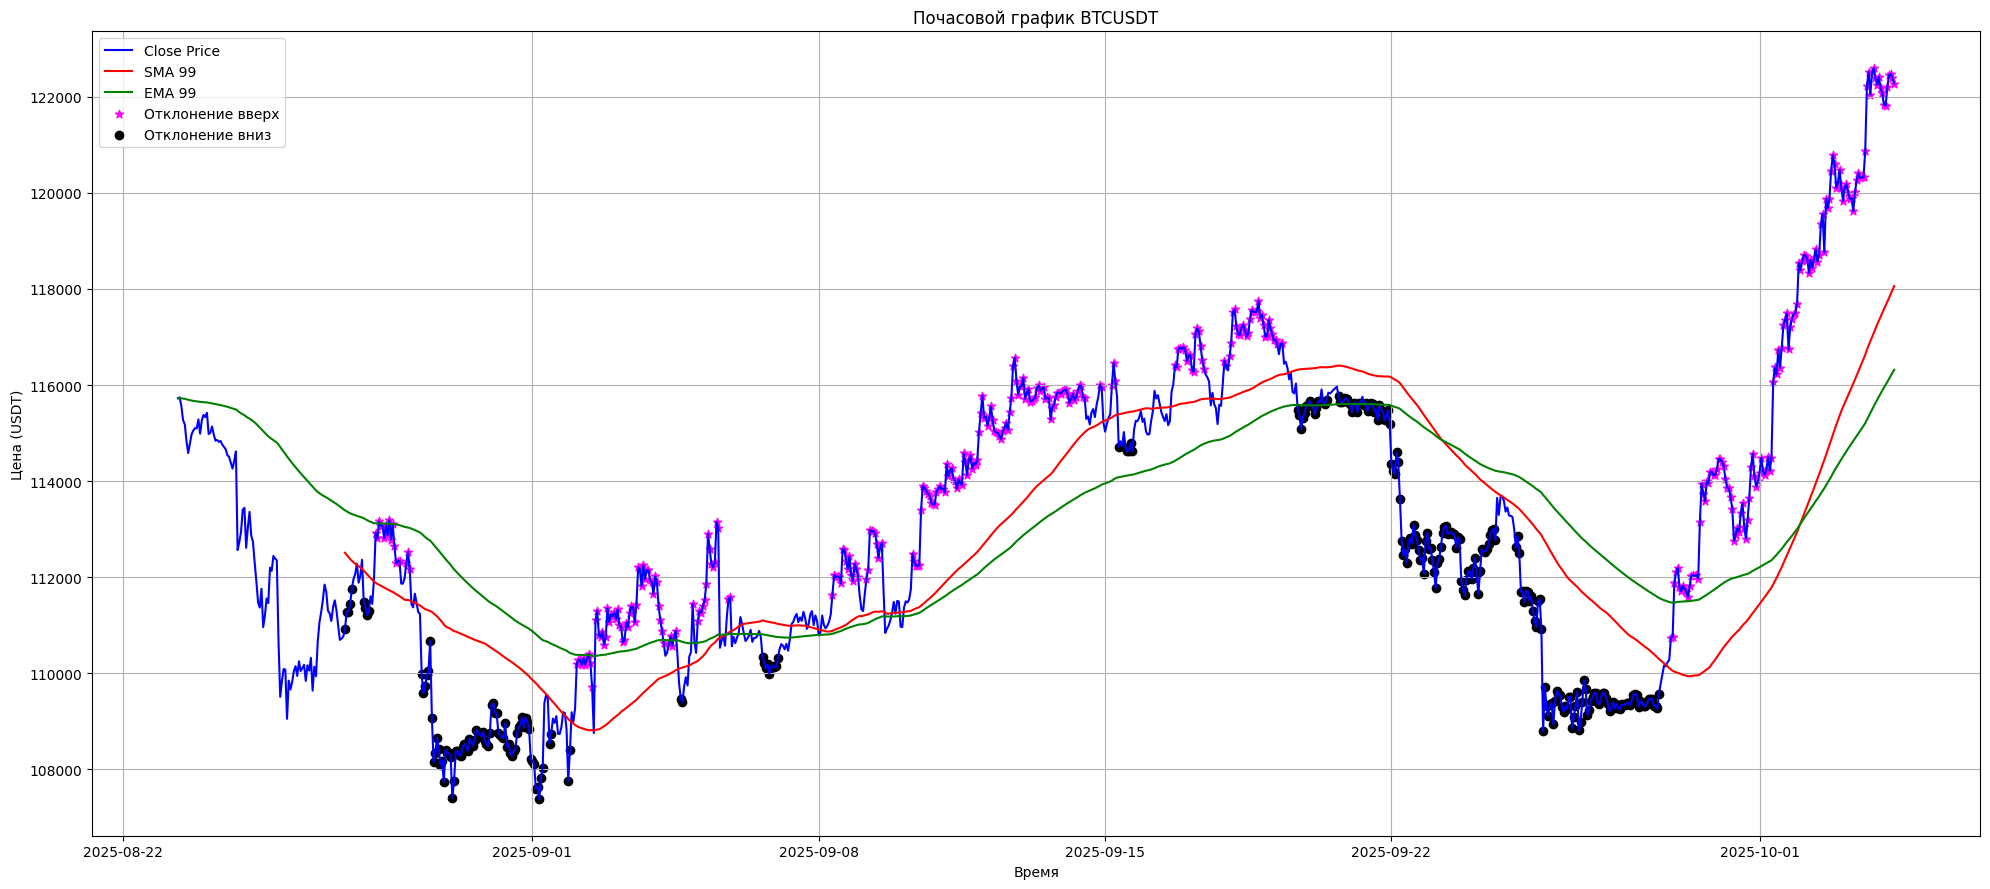

Готово! Всего свечей: 1008
                  timestamp      open      high       low     close  \
0 2025-08-23 08:00:00+00:00  115769.3  115836.2  115574.6  115724.1   
1 2025-08-23 09:00:00+00:00  115724.1  115760.7  115587.6  115742.6   
2 2025-08-23 10:00:00+00:00  115742.6  115751.5  115560.7  115560.7   
3 2025-08-23 11:00:00+00:00  115560.7  115597.1  115186.1  115266.6   
4 2025-08-23 12:00:00+00:00  115266.6    115450  115138.2  115184.4   

      volume      quoteVolume  SMA            EMA  diff  
0  1117.3342   129327362.0049  NaN  115724.100000   NaN  
1   750.0252     86744376.506  NaN  115724.285000   NaN  
2   605.5254   70022444.15696  NaN  115722.649150   NaN  
3   2074.582  239424002.40888  NaN  115718.088659   NaN  
4   1730.897  199512578.99406  NaN  115712.751772   NaN                        timestamp      open      high       low     close  \
1003 2025-10-04 03:00:00+00:00  121817.5    122300  121792.8  122207.4   
1004 2025-10-04 04:00:00+00:00  122207.4  122476.7

<Figure size 640x480 with 0 Axes>

In [4]:
if __name__ == "__main__":
    # Подключаемся к API
    client = Bitget(symbol="BTCUSDT", product_type="USDT-FUTURES", granularity="1H")

    # Загружаем свечи
    load = LoadingCandle(client, days=365)
    candles = load.get_candle()

    # Обрабатываем данные
    processor = CandleProcesssing(candles)
    df = processor.prepare()
    processor.save_candle("candles_1hd.csv")

    # Индикаторы
    window = int(input("Введите ширину окна: "))
    calc = TechIndicator(df)
    df = calc.add_indicators(window=window)

    # График
    plotter = PriceGraph(df, client.symbol)
    plotter.plot(window, calc.alerts_up, calc.alerts_down)

    print(f"Готово! Всего свечей: {len(df)}")
    print(df.head(), df.tail())